In [ ]:
import numpy as np
#Constructing the array responses for AoA candidates
"""
************** Input
phi_min: Lower-bound of AoAs
phi_max: Upper-bound of AoAs
N: # Antennas
delta_inv: # Coarse AoA Candidates (Intervals)
delta_inv_OS: # AoA Candidates (After over-sampling)
************** Ouput 
phi: Coarse AoA Candidates   
A_BS: Collection of array responses for Coarse AoA Candidates
phi: AoA Candidates   
A_BS: Collection of array responses for AoA Candidates
"""
def func_codedesign_cont(delta_inv,delta_inv_OS,phi_min,phi_max,N):
    delta_theta = (phi_max-phi_min)/delta_inv;
    phi = np.linspace(start=phi_min+delta_theta/2,stop=phi_max-delta_theta/2,num=delta_inv) 
    from0toN = np.float32(list(range(0, N)))
    A_BS = np.zeros([N,delta_inv],dtype=np.complex64)
    for i in range(delta_inv):
        a_phi = np.exp(1j*np.pi*from0toN*np.sin(phi[i]))
        A_BS[:,i] = np.transpose(a_phi)

    delta_theta = (phi_max-phi_min)/delta_inv_OS
    phi_OS = np.linspace(start=phi_min+delta_theta/2,stop=phi_max-delta_theta/2,num=delta_inv_OS)  
    A_BS_OS = np.zeros([N,delta_inv_OS],dtype=np.complex64)
    for i in range(delta_inv_OS):
        a_phi = np.exp(1j*np.pi*from0toN*np.sin(phi_OS[i]))
        A_BS_OS[:,i] = np.transpose(a_phi)
        
    return A_BS, phi, A_BS_OS, phi_OS   

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import random as random
from mpl_toolkits import mplot3d

def generate_location(num_users):
    location_user = np.empty([num_users, 3])
    for k in range(num_users):
        #x = np.random.uniform(5, 55) 
        #y = np.random.uniform(-35, 35)
        x = np.random.uniform(5, 35) 
        y = np.random.uniform(-35, 35)
        z = -20
        coordinate_k = np.array([x, y, z])
        location_user[k, :] = coordinate_k
    return location_user

def generate_location_2D(num_users):
    location_user = np.empty([num_users, 2])
    for k in range(num_users):
        x = np.random.uniform(5, 35) 
        y = np.random.uniform(-35, 35)
        coordinate_k = np.array([x, y])
        location_user[k, :] = coordinate_k
    return location_user



def path_loss_r(d):
    loss = 30 + 22.0 * np.log10(d)
    return loss


def path_loss_d(d):
    loss = 32.6 + 36.7 * np.log10(d)
    return loss


def generate_pathloss_aoa_aod(location_user, location_bs, location_irs):
    """
    :param location_user: array (num_user,2)
    :param location_bs: array (2,)
    :param location_irs: array (2,)
    :return: pathloss = (pathloss_irs_bs, pathloss_irs_user, pathloss_bs_user)
            cos_phi = (cos_phi_1, cos_phi_2, cos_phi_3)
    """
    num_user = location_user.shape[0]
    # ========bs-irs==============
    d0 = np.linalg.norm(location_bs - location_irs)
    pathloss_irs_bs = path_loss_r(d0)
    aoa_bs = ( location_irs[0] - location_bs[0]) / d0
    aod_irs_y = (location_bs[1]-location_irs[1]) / d0
    aod_irs_z = (location_bs[2]-location_irs[2]) / d0
    # =========irs-user=============
    pathloss_irs_user = []
    aoa_irs_y = []
    aoa_irs_z = []
    for k in range(num_user):
        d_k = np.linalg.norm(location_user[k] - location_irs)
        pathloss_irs_user.append(path_loss_r(d_k))
        aoa_irs_y_k = (location_user[k][1] - location_irs[1]) / d_k
        aoa_irs_z_k = (location_user[k][2] - location_irs[2]) / d_k
        aoa_irs_y.append(aoa_irs_y_k)
        aoa_irs_z.append(aoa_irs_z_k)
    aoa_irs_y = np.array(aoa_irs_y)
    aoa_irs_z = np.array(aoa_irs_z)

    # =========bs-user=============
    pathloss_bs_user = np.zeros([num_user, 1])
    for k in range(num_user):
        d_k = np.linalg.norm(location_user[k] - location_bs)
        pathloss_bs_user_k = path_loss_d(d_k)
        pathloss_bs_user[k, :] = pathloss_bs_user_k

    pathloss = (pathloss_irs_bs, np.array(pathloss_irs_user), np.array(pathloss_bs_user))
    aoa_aod = (aoa_bs, aod_irs_y, aod_irs_z, aoa_irs_y, aoa_irs_z)
    return pathloss, aoa_aod

def generate_pathloss_aoa_aod_fullRician(location_user, location_bs, location_irs):
    """
    :param location_user: array (num_user,2)
    :param location_bs: array (2,)
    :param location_irs: array (2,)
    :return: pathloss = (pathloss_irs_bs, pathloss_irs_user, pathloss_bs_user)
            cos_phi = (cos_phi_1, cos_phi_2, cos_phi_3)
    """
    num_user = location_user.shape[0]
    # ========bs-irs==============
    d0 = np.linalg.norm(location_bs - location_irs)
    pathloss_irs_bs = path_loss_r(d0)
    aoa_bs = ( location_irs[0] - location_bs[0]) / d0
    aod_irs_y = (location_bs[1]-location_irs[1]) / d0
    aod_irs_z = (location_bs[2]-location_irs[2]) / d0
    # =========irs-user=============
    pathloss_irs_user = []
    aoa_irs_y = []
    aoa_irs_z = []
    for k in range(num_user):
        d_k = np.linalg.norm(location_user[k] - location_irs)
        pathloss_irs_user.append(path_loss_r(d_k))
        aoa_irs_y_k = (location_user[k][1] - location_irs[1]) / d_k
        aoa_irs_z_k = (location_user[k][2] - location_irs[2]) / d_k
        aoa_irs_y.append(aoa_irs_y_k)
        aoa_irs_z.append(aoa_irs_z_k)
    aoa_irs_y = np.array(aoa_irs_y)
    aoa_irs_z = np.array(aoa_irs_z)

    # =========bs-user=============
    aoa_bs_y = []
    aoa_bs_z = []
    pathloss_bs_user = np.zeros([num_user, 1])
    for k in range(num_user):
        d_k = np.linalg.norm(location_user[k] - location_bs)
        pathloss_bs_user_k = path_loss_d(d_k)
        pathloss_bs_user[k, :] = pathloss_bs_user_k
        aod_bs_k_y = (location_bs[1]-location_irs[1]) / d_k
        aod_bs_k_z = (location_bs[2]-location_irs[2]) / d_k
        aoa_bs_y.append(aod_bs_k_y)
        aoa_bs_z.append(aod_bs_k_z)
    aoa_bs_y = np.array(aoa_bs_y)
    aoa_bs_z = np.array(aoa_bs_z)

    pathloss = (pathloss_irs_bs, np.array(pathloss_irs_user), np.array(pathloss_bs_user))
    aoa_aod = (aoa_bs, aod_irs_y, aod_irs_z, aoa_irs_y, aoa_irs_z, aoa_bs_y , aoa_bs_z)
    return pathloss, aoa_aod

def generate_pathloss_aoa_aod_2D(location_user, location_bs, location_irs):
    """
    :param location_user: array (num_user,2)
    :param location_bs: array (2,)
    :param location_irs: array (2,)
    :return: pathloss = (pathloss_irs_bs, pathloss_irs_user, pathloss_bs_user)
            cos_phi = (cos_phi_1, cos_phi_2, cos_phi_3)
    """
    num_user = location_user.shape[0]
    # ========bs-irs==============
    d0 = np.linalg.norm(location_bs - location_irs)
    pathloss_irs_bs = path_loss_r(d0)
    aoa_bs = ( location_irs[0] - location_bs[0]) / d0
    aod_irs_y = (location_bs[1]-location_irs[1]) / d0
    #aod_irs_z = (location_bs[2]-location_irs[2]) / d0
    # =========irs-user=============
    pathloss_irs_user = []
    aoa_irs_y = []
    #aoa_irs_z = []
    for k in range(num_user):
        d_k = np.linalg.norm(location_user[k] - location_irs)
        pathloss_irs_user.append(path_loss_r(d_k))
        aoa_irs_y_k = (location_user[k][1] - location_irs[1]) / d_k
        #aoa_irs_z_k = (location_user[k][2] - location_irs[2]) / d_k
        aoa_irs_y.append(aoa_irs_y_k)
        #aoa_irs_z.append(aoa_irs_z_k)
    aoa_irs_y = np.array(aoa_irs_y)
    #aoa_irs_z = np.array(aoa_irs_z)

    # =========bs-user=============
    pathloss_bs_user = np.zeros([num_user, 1])
    for k in range(num_user):
        d_k = np.linalg.norm(location_user[k] - location_bs)
        pathloss_bs_user_k = path_loss_d(d_k)
        pathloss_bs_user[k, :] = pathloss_bs_user_k

    pathloss = (pathloss_irs_bs, np.array(pathloss_irs_user), np.array(pathloss_bs_user))
    aoa_aod = (aoa_bs, aod_irs_y, aoa_irs_y)
    return pathloss, aoa_aod

######################################################################################################################## distance not halfed
def generate_channel(params_system, location_bs=np.array([100, -100, 0]), location_irs=np.array([0, 0, 0]),
                     location_user_initial=None, Rician_factor=10, scale_factor=100, num_samples=100,irs_Nh = 16):
    # scale_factor: can be viewed as (downlink noise_power_dB- downlink Pt)

    (num_antenna_bs, num_elements_irs, num_user) = params_system

    channel_bs_irs, channel_bs_user, channel_irs_user, set_location_user = [], [], [], []
    for ii in range(num_samples):
        if location_user_initial is None:
            location_user = generate_location(num_user)
            set_location_user.append(location_user)
        else:
            location_user = location_user_initial
            set_location_user.append(location_user)

        pathloss, aoa_aod = generate_pathloss_aoa_aod(location_user, location_bs, location_irs)
        (pathloss_irs_bs, pathloss_irs_user, pathloss_bs_user) = pathloss
        (aoa_bs, aod_irs_y, aod_irs_z, aoa_irs_y, aoa_irs_z) = aoa_aod

        pathloss_bs_user = pathloss_bs_user - scale_factor
        pathloss_irs_bs = pathloss_irs_bs - scale_factor / 2
        pathloss_irs_user = pathloss_irs_user - scale_factor / 2
        pathloss_bs_user = np.sqrt(10 ** ((-pathloss_bs_user) / 10))
        pathloss_irs_user = np.sqrt(10 ** ((-pathloss_irs_user) / 10))
        pathloss_irs_bs = np.sqrt(10 ** ((-pathloss_irs_bs) / 10))

        # tmp:(num_antenna_bs,num_user) channel between BS and user
        tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_user]) \
              + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_user])
        tmp = tmp * pathloss_bs_user.reshape(1, num_user)

        # ######################################################################
        # # some user have LOS, some does not have LOS, make hd equal to 0.
        
        # user_no_los = random.sample(range(0, num_user), int(np.floor(num_user/3)))
        # tmp[:,user_no_los] = np.zeros([num_antenna_bs,1])
        # #tmp[:,user_no_los] = [0.0000000001]
        
        # ######################################################################
        channel_bs_user.append(tmp)

        # tmp: (num_antenna_bs,num_elements_irs) channel between IRS and BS
        tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_elements_irs]) \
              + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_elements_irs])
        a_bs = np.exp(1j * np.pi * aoa_bs * np.arange(num_antenna_bs))
        a_bs = np.reshape(a_bs, [num_antenna_bs, 1])

        i1 = np.mod(np.arange(num_elements_irs),irs_Nh)
        i2 = np.floor(np.arange(num_elements_irs)/irs_Nh)
        a_irs_bs = np.exp(1j * np.pi * (i1*aod_irs_y+i2*aod_irs_z))
        a_irs_bs =  np.reshape(a_irs_bs, [num_elements_irs, 1])
        los_irs_bs = a_bs @ np.transpose(a_irs_bs.conjugate())
        tmp = np.sqrt(Rician_factor / (1 + Rician_factor)) * los_irs_bs + np.sqrt(1/(1 + Rician_factor)) * tmp
        tmp = tmp * pathloss_irs_bs
        channel_bs_irs.append(tmp)

        # tmp:(num_elements_irs,num_user) channel between IRS and user
        tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_elements_irs, num_user]) \
              + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_elements_irs, num_user])
        for k in range(num_user):
            a_irs_user = np.exp(1j * np.pi * (i1 * aoa_irs_y[k] + i2 * aoa_irs_z[k]))
            tmp[:, k] = np.sqrt(Rician_factor/(1+Rician_factor))*a_irs_user+np.sqrt(1/(1+Rician_factor))*tmp[:, k]
            tmp[:, k] = tmp[:, k] * pathloss_irs_user[k]
        channel_irs_user.append(tmp)
    channels = (np.array(channel_bs_user), np.array(channel_irs_user), np.array(channel_bs_irs))
    return channels, set_location_user

def generate_channel_fullRician(params_system, location_bs=np.array([100, -100, 0]), location_irs=np.array([0, 0, 0]),
                     location_user_initial=None, Rician_factor=10, scale_factor=100, num_samples=100,irs_Nh = 16):
    # scale_factor: can be viewed as (downlink noise_power_dB- downlink Pt)

    (num_antenna_bs, num_elements_irs, num_user) = params_system

    channel_bs_irs, channel_bs_user, channel_irs_user, set_location_user = [], [], [], []
    for ii in range(num_samples):
        if location_user_initial is None:
            location_user = generate_location(num_user)
            set_location_user.append(location_user)
        else:
            location_user = location_user_initial
            set_location_user.append(location_user)

        pathloss, aoa_aod = generate_pathloss_aoa_aod_fullRician(location_user, location_bs, location_irs)
        (pathloss_irs_bs, pathloss_irs_user, pathloss_bs_user) = pathloss
        (aoa_bs, aod_irs_y, aod_irs_z, aoa_irs_y, aoa_irs_z, aoa_bs_y, aoa_bs_z) = aoa_aod

        pathloss_bs_user = pathloss_bs_user - scale_factor
        pathloss_irs_bs = pathloss_irs_bs - scale_factor / 2
        pathloss_irs_user = pathloss_irs_user - scale_factor / 2
        pathloss_bs_user = np.sqrt(10 ** ((-pathloss_bs_user) / 10))
        pathloss_irs_user = np.sqrt(10 ** ((-pathloss_irs_user) / 10))
        pathloss_irs_bs = np.sqrt(10 ** ((-pathloss_irs_bs) / 10))

        # tmp:(num_antenna_bs,num_user) channel between BS and user
        tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_user]) \
              + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_user])
        i1 = np.arange(1)
        for k in range(num_user):
            a_bs_user = np.exp(1j * np.pi * 0)
            tmp[:, k] = np.sqrt(Rician_factor/(1+Rician_factor))*a_bs_user+np.sqrt(1/(1+Rician_factor))*tmp[:, k]
            tmp[:, k] = tmp[:, k] * pathloss_bs_user[k]
 
        channel_bs_user.append(tmp)

        #################        channel between IRS and BS
        tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_elements_irs]) \
              + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_elements_irs])
        a_bs = np.exp(1j * np.pi * aoa_bs * np.arange(num_antenna_bs))
        a_bs = np.reshape(a_bs, [num_antenna_bs, 1])

        i1 = np.mod(np.arange(num_elements_irs),irs_Nh)
        i2 = np.floor(np.arange(num_elements_irs)/irs_Nh)
        a_irs_bs = np.exp(1j * np.pi * (i1*aod_irs_y+i2*aod_irs_z))
        a_irs_bs =  np.reshape(a_irs_bs, [num_elements_irs, 1])
        los_irs_bs = a_bs @ np.transpose(a_irs_bs.conjugate())
        tmp = np.sqrt(Rician_factor / (1 + Rician_factor)) * los_irs_bs + np.sqrt(1/(1 + Rician_factor)) * tmp
        tmp = tmp * pathloss_irs_bs
        channel_bs_irs.append(tmp)

        ###############         channel between IRS and user
        tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_elements_irs, num_user]) \
              + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_elements_irs, num_user])
        for k in range(num_user):
            a_irs_user = np.exp(1j * np.pi * (i1 * aoa_irs_y[k] + i2 * aoa_irs_z[k]))
            tmp[:, k] = np.sqrt(Rician_factor/(1+Rician_factor))*a_irs_user+np.sqrt(1/(1+Rician_factor))*tmp[:, k]
            tmp[:, k] = tmp[:, k] * pathloss_irs_user[k]
        channel_irs_user.append(tmp)
    channels = (np.array(channel_bs_user), np.array(channel_irs_user), np.array(channel_bs_irs))
    return channels, set_location_user


def generate_channel_2D(params_system, location_bs=np.array([100, -100]), location_irs=np.array([0, 0]),
                     location_user_initial=None, Rician_factor=10, scale_factor=100, num_samples=100,irs_Nh = 16):

    (num_antenna_bs, num_elements_irs, num_user) = params_system

    channel_bs_irs, channel_bs_user, channel_irs_user, set_location_user = [], [], [], []
    aoa_irs_y_set = []
    pathloss_irs_user_set = []
    for ii in range(num_samples):
        if location_user_initial is None:
            location_user = generate_location_2D(num_user)
            set_location_user.append(location_user)
        else:
            location_user = location_user_initial
            set_location_user.append(location_user)

        pathloss, aoa_aod = generate_pathloss_aoa_aod_2D(location_user, location_bs, location_irs)
        (pathloss_irs_bs, pathloss_irs_user, pathloss_bs_user) = pathloss
        (aoa_bs, aod_irs_y, aoa_irs_y) = aoa_aod

        pathloss_bs_user = pathloss_bs_user - scale_factor
        pathloss_irs_bs = pathloss_irs_bs - scale_factor / 2
        pathloss_irs_user = pathloss_irs_user - scale_factor / 2
        pathloss_bs_user = np.sqrt(10 ** ((-pathloss_bs_user) / 10))
        pathloss_irs_user = np.sqrt(10 ** ((-pathloss_irs_user) / 10))
        pathloss_irs_bs = np.sqrt(10 ** ((-pathloss_irs_bs) / 10))

        # tmp:(num_antenna_bs,num_user) channel between BS and user
        tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_user]) \
              + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_user])
        tmp = tmp * pathloss_bs_user.reshape(1, num_user)

        channel_bs_user.append(tmp)

        # tmp: (num_antenna_bs,num_elements_irs) channel between IRS and BS
        tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_elements_irs]) \
              + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_antenna_bs, num_elements_irs])
        a_bs = np.exp(1j * np.pi * aoa_bs * np.arange(num_antenna_bs))
        a_bs = np.reshape(a_bs, [num_antenna_bs, 1])

        i1 = np.arange(num_elements_irs)
        i2 = np.floor(np.arange(num_elements_irs)/irs_Nh)
        #a_irs_bs = np.exp(1j * np.pi * (i1*aod_irs_y+i2*aod_irs_z))
        a_irs_bs = np.exp(1j * np.pi * (i1*aod_irs_y))
        a_irs_bs =  np.reshape(a_irs_bs, [num_elements_irs, 1])
        los_irs_bs = a_bs @ np.transpose(a_irs_bs.conjugate())
        tmp = np.sqrt(Rician_factor / (1 + Rician_factor)) * los_irs_bs + np.sqrt(1/(1 + Rician_factor)) * tmp
        tmp = tmp * pathloss_irs_bs
        channel_bs_irs.append(tmp)

        # tmp:(num_elements_irs,num_user) channel between IRS and user
        tmp = np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_elements_irs, num_user]) \
              + 1j * np.random.normal(loc=0, scale=np.sqrt(0.5), size=[num_elements_irs, num_user])
        for k in range(num_user):
            #a_irs_user = np.exp(1j * np.pi * (i1 * aoa_irs_y[k] + i2 * aoa_irs_z[k]))
            a_irs_user = np.exp(1j * np.pi * (i1* aoa_irs_y[k]))
            if num_user ==1:
                aoa_irs_y_set.append(aoa_irs_y[k])
                pathloss_irs_user_set.append(pathloss_irs_user)
            else:
                raise RuntimeError('number user greater than 1 !')
            
            tmp[:, k] = np.sqrt(Rician_factor/(1+Rician_factor))*a_irs_user+np.sqrt(1/(1+Rician_factor))*tmp[:, k]
            tmp[:, k] = tmp[:, k] * pathloss_irs_user[k]
        channel_irs_user.append(tmp)
    channels = (np.array(channel_bs_user), np.array(channel_irs_user), np.array(channel_bs_irs))
    return channels, np.array(set_location_user), np.array(aoa_irs_y_set), np.array(pathloss_irs_user_set)



def channel_complex2real(channels):
    channel_bs_user, channel_irs_user, channel_bs_irs = channels
    (num_sample, num_antenna_bs, num_elements_irs) = channel_bs_irs.shape
    num_user = channel_irs_user.shape[2]

    A_T_real = np.zeros([num_sample, 2 * num_elements_irs, 2 * num_antenna_bs, num_user])
    # Hd_real = np.zeros([num_sample, 2 * num_antenna_bs, num_user])
    set_channel_combine_irs = np.zeros([num_sample, num_antenna_bs, num_elements_irs, num_user], dtype=complex)

    for kk in range(num_user):
        channel_irs_user_k = channel_irs_user[:, :, kk]
        channel_combine_irs = channel_bs_irs * channel_irs_user_k.reshape(num_sample, 1, num_elements_irs)
        set_channel_combine_irs[:, :, :, kk] = channel_combine_irs
        A_tmp_tran = np.transpose(channel_combine_irs, (0, 2, 1))
        A_tmp_real1 = np.concatenate([A_tmp_tran.real, A_tmp_tran.imag], axis=2)
        A_tmp_real2 = np.concatenate([-A_tmp_tran.imag, A_tmp_tran.real], axis=2)
        A_tmp_real = np.concatenate([A_tmp_real1, A_tmp_real2], axis=1)
        A_T_real[:, :, :, kk] = A_tmp_real

    Hd_real = np.concatenate([channel_bs_user.real, channel_bs_user.imag], axis=1)

    return A_T_real, Hd_real, np.array(set_channel_combine_irs)



Instructions for updating:
non-resource variables are not supported in the long term
Mounted at /content/drive
Instructions for updating:
Colocations handled automatically by placer.
Tensor("Mean:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/ris_localization_2D_fixedi1/RNN/closeBS_largeUEdistribution/params_new_closeBS_fullRician_RSS_3D_RIS_tau_6_snr_35
3.9308102
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
epoch 0   loss_test:4.66306   best_test:3.93081
epoch 1   loss_test:5.38646   best_test:3.93081
epoch 2   loss_test:5.43013   best_test:3.93081
epoch 3   loss_test:7.19782   best_test:3.93081
epoch 4   loss_test:4.75247   best_test:3.93081
epoch 5   loss_test:8.58432   best_test:3.93081
epoch 6   loss_test:6.59458   best_test:3.93081
epoch 7   loss_test:6.46244   best_test:3.93081
epoch 8   loss_test:5.21666   best_test:3.93081
epoch 9   loss_test:6.87246   best_test:3.93081
epoch 10   loss_test

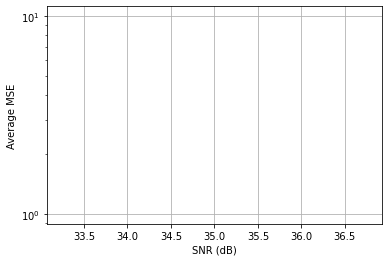

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import keras.layers.normalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense
#from wsr.bcd.generate_received_pilots import generate_received_pilots_batch


# these three lines are needed if using google colab, otherwise can delete
from google.colab import drive
drive.mount('/content/drive')
drive_save_path = '/content/drive/MyDrive/'

'System Information'
N = 1   #Number of BS's antennas
delta_inv = 128 #Number of posterior intervals inputed to DNN 
delta = 1/delta_inv 
S = np.log2(delta_inv) 
OS_rate = 20 #Over sampling rate in each AoA interval (N_s in the paper)
delta_inv_OS = OS_rate*delta_inv #Total number of AoAs for posterior computation
delta_OS = 1/delta_inv_OS 
'Channel Information'
phi_min = -60*(np.pi/180) #Lower-bound of AoAs
phi_max = 60*(np.pi/180) #Upper-bound of AoAs
num_SNR = 8 #Number of considered SNRs

  #  x = np.random.uniform(5, 55) 
  #  y = np.random.uniform(-35, 35)

location_bs_new = np.array([40, -40, 0])
tau =  6 #Pilot length

snr_const = 35 #The SNR
snr_const = np.array([snr_const])
Pvec = 10**(snr_const/10) #Set of considered TX powers


mean_true_alpha = 0.0 + 0.0j #Mean of the fading coefficient
std_per_dim_alpha = np.sqrt(0.5) #STD of the Gaussian fading coefficient per real dim.
noiseSTD_per_dim = np.sqrt(0.5) #STD of the Gaussian noise per real dim.
#####################################################
'RIS'
N_ris = 64
num_users = 1
params_system = (N,N_ris,num_users)
Rician_factor = 10
location_user = None

#####################################################
'Learning Parameters'
initial_run = 0    #0: Continue training; 1: Starts from the scratch
if initial_run == 1:
  print('!!!!! training from scratch !!!!!')
n_epochs = 1000 #Num of epochs
learning_rate = 0.00005 #Learning rate
batch_per_epoch = 100 #Number of mini batches per epoch
batch_size_order = 8 #Mini_batch_size = batch_size_order*delta_inv
val_size_order = 782 #Validation_set_size = val_size_order*delta_inv
scale_factor = 1 #Scaling the number of tests
test_size_order = 782 #Test_set_size = test_size_order*delta_inv*scale_factor
######################################################
tf.reset_default_graph() #Reseting the graph
he_init = tf.variance_scaling_initializer() #Define initialization method
######################################## Place Holders
#alpha_input = tf.placeholder(tf.float32, shape=(None,1), name="alpha_input")
loc_input = tf.placeholder(tf.float32, shape=(None,1,3), name="loc_input")
channel_bs_irs_user = tf.placeholder(tf.float32, shape=(None, 2 * N_ris, 2 * N, num_users), name="channel_bs_irs_user")
channel_bs_user = tf.placeholder(tf.float32, shape=(None, 2 * N, num_users), name="channel_bs_irs_user")
######################################################
#Constructing the array responses for AoA samples
##################### NETWORK
with tf.name_scope("array_response_construction"):
    lay = {}
    lay['P'] = tf.constant(1.0)
    ###############
    from0toN = tf.cast(tf.range(0, N, 1),tf.float32)
    
with tf.name_scope("channel_sensing"):
    hidden_size = 512
    A1 = tf.get_variable("A1",  shape=[hidden_size,1024], dtype=tf.float32, initializer= he_init)
    A2 = tf.get_variable("A2",  shape=[1024,1024], dtype=tf.float32, initializer= he_init)
    A3 = tf.get_variable("A3",  shape=[1024,1024], dtype=tf.float32, initializer= he_init)
    A4 = tf.get_variable("A4",  shape=[1024,2*N_ris], dtype=tf.float32, initializer= he_init)
    
    b1 = tf.get_variable("b1",  shape=[1024], dtype=tf.float32, initializer= he_init)
    b2 = tf.get_variable("b2",  shape=[1024], dtype=tf.float32, initializer= he_init)
    b3 = tf.get_variable("b3",  shape=[1024], dtype=tf.float32, initializer= he_init)
    b4 = tf.get_variable("b4",  shape=[2*N_ris], dtype=tf.float32, initializer= he_init)
        
    w_dict = []
    posterior_dict = []
    idx_est_dict = []
    layer_Ui = Dense(units=hidden_size, activation='linear')
    layer_Wi = Dense(units=hidden_size, activation='linear')
    layer_Uf = Dense(units=hidden_size, activation='linear')
    layer_Wf = Dense(units=hidden_size, activation='linear')
    layer_Uo = Dense(units=hidden_size, activation='linear')
    layer_Wo = Dense(units=hidden_size, activation='linear')
    layer_Uc = Dense(units=hidden_size, activation='linear')
    layer_Wc = Dense(units=hidden_size, activation='linear')
    def RNN(input_x, h_old, c_old):
        i_t = tf.sigmoid(layer_Ui(input_x) + layer_Wi(h_old))
        f_t = tf.sigmoid(layer_Uf(input_x) + layer_Wf(h_old))
        o_t = tf.sigmoid(layer_Uo(input_x) + layer_Wo(h_old))
        c_t = tf.tanh(layer_Uc(input_x) + layer_Wc(h_old))
        c = i_t * c_t + f_t * c_old     # cell state
        h_new = o_t * tf.tanh(c)        # hidden state
        return h_new, c
    
    snr = lay['P']*tf.ones(shape=[tf.shape(loc_input)[0],1],dtype=tf.float32)
    snr_dB = tf.log(snr)/np.log(10)
    snr_normal = (snr_dB-1)/np.sqrt(1.6666) #Normalizing for the range -10dB to 30dB
    
    for t in range(tau):      
        'DNN designs the next sensing direction'
        if t == 0:
            RSS_val = tf.ones([tf.shape(loc_input)[0],1])
            h_old = tf.zeros([tf.shape(loc_input)[0],hidden_size])
            c_old = tf.zeros([tf.shape(loc_input)[0],hidden_size])
        h_old, c_old = RNN(tf.concat([RSS_val,snr_normal],axis=1), h_old, c_old)

        x1 = tf.nn.relu(h_old@A1+b1)
        x1 = BatchNormalization()(x1)
        x2 = tf.nn.relu(x1@A2+b2)
        x2 = BatchNormalization()(x2)
        x3 = tf.nn.relu(x2@A3+b3)
        x3 = BatchNormalization()(x3)
        '''
            RIS implementation
        '''
        ris_her_unnorm = x3 @ A4 + b4
        ris_her_r = ris_her_unnorm[:, 0:N_ris]
        ris_her_i = ris_her_unnorm[:, N_ris:2 * N_ris]                      # (? , N_ris)
        theta_tmp = tf.sqrt(tf.square(ris_her_r) + tf.square(ris_her_i))    # (? , N_ris)
        theta_real = ris_her_r / theta_tmp                                  # (? , N_ris)
        theta_imag = ris_her_i / theta_tmp                                  # (? , N_ris)
        theta = tf.concat([theta_real, theta_imag], axis=1)                 # (? , 2*N_ris)      hmmmmm
        #print('theta:', theta.shape)
        theta_T = tf.reshape(theta, [-1, 1, 2 * N_ris])                     # (? , 1 , 2 * N_ris)
        #print('theta_T:', theta_T.shape)                                   #  (?, 1, 128)

        'BS observes the next measurement'
        
        A_T_k = channel_bs_irs_user[:, :, :, 0] # since 1 user
        theta_A_k_T = tf.matmul(theta_T, A_T_k)                             # (? , 1 , 2 * N ) 

        h_d = channel_bs_user[:,:,0]
        h_d_T = tf.reshape(h_d, [-1, 1, 2 * N])

        h_d_plus_h_cas = h_d_T + theta_A_k_T
        h_d_plus_h_cas_re = h_d_plus_h_cas[:,:,0]
        h_d_plus_h_cas_im = h_d_plus_h_cas[:,:,1]
        noise =  tf.complex(tf.random_normal(tf.shape(h_d_plus_h_cas_re), mean = 0.0, stddev = noiseSTD_per_dim),\
                    tf.random_normal(tf.shape(h_d_plus_h_cas_re), mean = 0.0, stddev = noiseSTD_per_dim))
        y_complex = tf.complex(tf.sqrt(lay['P']),0.0)*tf.complex(h_d_plus_h_cas_re,h_d_plus_h_cas_im) + noise
        y_real = tf.concat([tf.real(y_complex),tf.imag(y_complex)],axis=1)/tf.sqrt(lay['P'])
        RSS_val = tf.math.square(tf.abs(y_complex))

    h_old, c_old = RNN(tf.concat([RSS_val,snr_normal],axis=1), h_old, c_old)
    loc_hat = Dense(units=3, activation='linear')(c_old)

####################################################################################
####### Loss Function
a = tf.math.reduce_euclidean_norm(loc_input[:,0,:]-loc_input[:,0,:], 1)
b = tf.math.reduce_euclidean_norm(loc_hat-loc_input[:,0,:], 1)
loss = tf.keras.losses.mean_squared_error(a, b)
print(loss)
####### Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")
init = tf.global_variables_initializer()
saver = tf.train.Saver()
#########################################################################
###########  Validation Set
channel_true_val, set_location_user_val = generate_channel_fullRician(params_system, location_bs = location_bs_new,
                                                        num_samples=val_size_order*delta_inv, location_user_initial=location_user, Rician_factor=Rician_factor)
(channel_bs_user_val, channel_irs_user_val, channel_bs_irs_val) = channel_true_val
A_T_real_val, Hd_real_val , channel_bs_irs_user_val = channel_complex2real(channel_true_val)
feed_dict_val = {loc_input: np.array(set_location_user_val),
                    channel_bs_irs_user: A_T_real_val,
                    channel_bs_user : Hd_real_val,
                    lay['P']: Pvec[0]}
###########  Training
with tf.Session() as sess:
    if initial_run == 1:
        init.run()
    else:
        saver.restore(sess, drive_save_path + '/params_new_closeBS_fullRician_RSS_3D_RIS_tau_'+ str(tau) +'_snr_'+ str(snr_const[0]))
    best_loss, pp = sess.run([loss,posterior_dict], feed_dict=feed_dict_val)
    print(best_loss)
    print(tf.test.is_gpu_available()) #Prints whether or not GPU is on
    for epoch in range(n_epochs):
        batch_iter = 0
        for rnd_indices in range(batch_per_epoch):

            snr_temp = snr_const[0]
            P_temp = 10**(snr_temp/10)
            
            '''
                RIS implementation
            '''
            channel_true_train, set_location_user_train = generate_channel_fullRician(params_system, location_bs = location_bs_new,
                                                        num_samples=batch_size_order*delta_inv,
                                                       location_user_initial=location_user, Rician_factor=Rician_factor)
            (channel_bs_user_train, channel_irs_user_train, channel_bs_irs_train) = channel_true_train
            A_T_real, Hd_real_train , channel_bs_irs_user_train = channel_complex2real(channel_true_train)
            #print(A_T_real.shape)
            #print(channel_bs_irs_user_train.shape)
            #print(channel_bs_user_train.shape) #(num_samples,1,1)
            #print(channel_irs_user_train.shape) # (num_samples,64,1)
            #print(channel_bs_irs_train.shape) # (num_samples,1,64)
            #print(aoa_irs_y_set_train.shape) # this is what we wanna estimate, shape: (num_sample,1)
            #print(pathloss_irs_user_set_train.shape)  # this is known  shape  (num_sample, )
            feed_dict_batch = {loc_input: np.array(set_location_user_train),
                              channel_bs_irs_user: A_T_real,
                               channel_bs_user : Hd_real_train,
                              lay['P']: P_temp}
            sess.run(training_op, feed_dict=feed_dict_batch)
            batch_iter += 1

        
        loss_val = sess.run(loss, feed_dict=feed_dict_val)
        print('epoch',epoch,'  loss_test:%2.5f'%loss_val,'  best_test:%2.5f'%best_loss) 
        #print('epoch',epoch,'  loss_test:',loss_val, 'best_test:',best_loss) 
        if epoch%2 == 1: #Every 10 iterations it checks if the validation performace is improved, then saves parameters
            if loss_val < best_loss:
                save_path = saver.save(sess, drive_save_path+'/params_new_closeBS_fullRician_RSS_3D_RIS_tau_'+ str(tau) +'_snr_'+ str(snr_const[0]))
                best_loss = loss_val

###########  Final Test    
    performance = np.zeros([1,scale_factor])
    for j in range(scale_factor):
        print(j)
       
        channel_true_test, set_location_user_test = generate_channel_fullRician(params_system, location_bs = location_bs_new,
                                                        num_samples=test_size_order*delta_inv,
                                                       location_user_initial=location_user, Rician_factor=Rician_factor)
        (channel_bs_user_test, channel_irs_user_test, channel_bs_irs_test) = channel_true_test
        A_T_real_test, Hd_real_test , channel_bs_irs_user_test = channel_complex2real(channel_true_test)
        
        feed_dict_test = {loc_input: np.array(set_location_user_test),
                            channel_bs_irs_user: A_T_real_test,
                            channel_bs_user : Hd_real_test,
                            lay['P']: Pvec[0]}
            
        mse_loss,phi_hat_test= sess.run([loss,loc_hat],feed_dict=feed_dict_test)
        performance[0,j] = mse_loss
            
    performance = np.mean(performance,axis=1)       
            
######### Plot the test result /params_unknownalpha_RIS_snr_'+ str(snr_const[0]))
plt.semilogy(snr_const, performance)        
plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Average MSE')
plt.show()
sio.savemat(drive_save_path+'/data_RNN_loc_closeBS_fullRician_RSS_3D_RIS_tau_'+ str(tau) +'_snr_'+ str(snr_const[0]) +'.mat',dict(performance= performance,\
                                       snr_const=snr_const,N=N,N_ris = N_ris,epoch = n_epochs,delta_inv=delta_inv,\
                                       mean_true_alpha=mean_true_alpha,\
                                       std_per_dim_alpha=std_per_dim_alpha,\
                                       noiseSTD_per_dim=noiseSTD_per_dim, tau=tau))

